In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from itertools import combinations
from random import shuffle
from time import sleep
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import os
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random
import lightgbm as lgb

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [5]:
train_dtypes = pd.read_csv('../input/train8_dtypes.csv')
test_dtypes = pd.read_csv('../input/test8_dtypes.csv')
train_dtypes.index = train_dtypes['TransactionID']
del train_dtypes['TransactionID']
test_dtypes.index = test_dtypes['TransactionID']
del test_dtypes['TransactionID']
train_dtypes = train_dtypes.iloc[:,0]
test_dtypes = test_dtypes.iloc[:,0]
print(type(train_dtypes),type(test_dtypes))
train_dtypes = train_dtypes.to_dict()
test_dtypes = test_dtypes.to_dict()
gc.collect()

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


21

In [6]:
%%time
train = pd.read_csv('../input/train8.csv',dtype= train_dtypes)
print("train finished")

train finished
CPU times: user 2min 31s, sys: 4.87 s, total: 2min 36s
Wall time: 2min 36s


In [7]:
%%time
test = pd.read_csv('../input/test8.csv',dtype= test_dtypes)
print("test finished")

test finished
CPU times: user 2min 8s, sys: 2.94 s, total: 2min 11s
Wall time: 2min 11s


In [8]:
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(train.shape,test.shape,sample_submission.shape)

(590540, 1923) (506691, 1922) (506691, 2)


In [9]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  card1  \
0        2987000        0          86400            68.5          4   2386   
1        2987001        0          86401            29.0          4    315   
2        2987002        0          86469            59.0          4    658   
3        2987003        0          86499            50.0          4   3165   
4        2987004        0          86506            50.0          1    631   

   card2  card3  card4  card5  addr1  addr2  dist1  dist2  P_emaildomain  \
0    297      7      1     18     27      2     19     14              0   
1    173      7      2      1     29      2    497     14             17   
2    228      7      4      9     31      2    498     14             36   
3    277      7      2      2     44      2    497     14             54   
4    242      7      2      1     36      2    497     14             17   

   R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0              0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
1              0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2              0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
3              0  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
4              0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

    C13  C14     D1     D2    D3    D4   D5   D10    D11    D15  M1  M2  M3  \
0   1.0  1.0   14.0    NaN  13.0   NaN  NaN  13.0   13.0    0.0   1   1   1   
1   1.0  1.0    0.0    NaN   NaN   0.0  NaN   0.0    NaN    0.0   2   2   2   
2   1.0  1.0    0.0    NaN   NaN   0.0  NaN   0.0  315.0  315.0   1   1   1   
3  25.0  1.0  112.0  112.0   0.0  94.0  0.0  84.0    NaN  111.0   2   2   2   
4   1.0  1.0    0.0    NaN   NaN   NaN  NaN   NaN    NaN    NaN   2   2   2   

   M4  M5  M6  M7  M8  M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  \
0   2   0   1   2   2   2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   
1   0   1   1   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   0   0   0   0   0   0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   
3   0   1   0   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4   3   2   2   2   2   2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  \
0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
2  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN   
1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
1  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
3  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  \
0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  

# Train data is subsampled

In [10]:
train_0 = train[train['isFraud'] == 0].sample(frac = 0.2)
train_1 = train[train['isFraud'] == 1]
del train
gc.collect()
print(train_0.shape,train_1.shape)
train = pd.concat([train_0,train_1],axis=0)
train = train.sample(frac=1.0)
train = train.reset_index(drop=True)
print(train.shape,test.shape)
del train_0,train_1
gc.collect()

(113975, 1923) (20663, 1923)
(134638, 1923) (506691, 1922)


10

# Training

In [11]:
train.drop(['TransactionID','TransactionDT','dayofyear','day'],axis=1,inplace=True)
test.drop(['TransactionID','TransactionDT','dayofyear','day'],axis=1,inplace=True)
gc.collect()

14

In [12]:
y = train['isFraud']
del train['isFraud']

In [15]:
########################### Model params
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.04,
                    'num_leaves': 2**8,
                    'max_depth':12,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':500,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 51,
                    'early_stopping_rounds':100, 
                } 

In [16]:
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.columns)
scores = []
y_pred = np.zeros(test.shape[0])
oof = np.zeros(train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(kf.split(train, y), 1):
    print('Fold {}'.format(fold))
          
    trn_data = lgb.Dataset(train.iloc[trn_idx, :].values, label=y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train.iloc[val_idx, :].values, label=y.iloc[val_idx].values)   
    
    clf = lgb.train(lgb_params, trn_data ,valid_sets=[trn_data, val_data], verbose_eval=100)

    predictions = clf.predict(train.iloc[val_idx, :].values) 
    importance.iloc[:, fold - 1] = clf.feature_importance()
    oof[val_idx] = predictions

    score = roc_auc_score(y.iloc[val_idx].values, predictions)
    scores.append(score)
    print('Fold {} ROC AUC Score {}\n'.format(fold, score))

    y_pred += clf.predict(test) / N
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(scores), np.std(scores)))

Fold 1


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.984815	valid_1's auc: 0.954133
[200]	training's auc: 0.996058	valid_1's auc: 0.965327
[300]	training's auc: 0.999245	valid_1's auc: 0.969604
[400]	training's auc: 0.999885	valid_1's auc: 0.971606
[500]	training's auc: 0.999987	valid_1's auc: 0.972711
[600]	training's auc: 0.999999	valid_1's auc: 0.973505
[700]	training's auc: 1	valid_1's auc: 0.973994
[800]	training's auc: 1	valid_1's auc: 0.973983
[900]	training's auc: 1	valid_1's auc: 0.974062
[1000]	training's auc: 1	valid_1's auc: 0.974068
Did not meet early stopping. Best iteration is:
[961]	training's auc: 1	valid_1's auc: 0.974061
Fold 1 ROC AUC Score 0.9740607296923164

Fold 2


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.985146	valid_1's auc: 0.951543
[200]	training's auc: 0.996393	valid_1's auc: 0.962434
[300]	training's auc: 0.999269	valid_1's auc: 0.966604
[400]	training's auc: 0.999892	valid_1's auc: 0.968377
[500]	training's auc: 0.999992	valid_1's auc: 0.969593
[600]	training's auc: 1	valid_1's auc: 0.970229
[700]	training's auc: 1	valid_1's auc: 0.970472
[800]	training's auc: 1	valid_1's auc: 0.970669
[900]	training's auc: 1	valid_1's auc: 0.970901
Early stopping, best iteration is:
[819]	training's auc: 1	valid_1's auc: 0.970733
Fold 2 ROC AUC Score 0.9707334018827526

Fold 3


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.985381	valid_1's auc: 0.953031
[200]	training's auc: 0.996089	valid_1's auc: 0.963507
[300]	training's auc: 0.999093	valid_1's auc: 0.9681
[400]	training's auc: 0.99986	valid_1's auc: 0.970472
[500]	training's auc: 0.999986	valid_1's auc: 0.971635
[600]	training's auc: 0.999999	valid_1's auc: 0.97245
[700]	training's auc: 1	valid_1's auc: 0.972894
[800]	training's auc: 1	valid_1's auc: 0.972922
[900]	training's auc: 1	valid_1's auc: 0.973114
[1000]	training's auc: 1	valid_1's auc: 0.973207
Did not meet early stopping. Best iteration is:
[923]	training's auc: 1	valid_1's auc: 0.973075
Fold 3 ROC AUC Score 0.9730750054740512

Fold 4


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.984906	valid_1's auc: 0.957932
[200]	training's auc: 0.99618	valid_1's auc: 0.967776
[300]	training's auc: 0.999122	valid_1's auc: 0.971368
[400]	training's auc: 0.99987	valid_1's auc: 0.973126
[500]	training's auc: 0.999985	valid_1's auc: 0.974249
[600]	training's auc: 0.999999	valid_1's auc: 0.97494
[700]	training's auc: 1	valid_1's auc: 0.975409
[800]	training's auc: 1	valid_1's auc: 0.975717
[900]	training's auc: 1	valid_1's auc: 0.975859
Early stopping, best iteration is:
[807]	training's auc: 1	valid_1's auc: 0.975778
Fold 4 ROC AUC Score 0.9757781017634128

Fold 5


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.984554	valid_1's auc: 0.954434
[200]	training's auc: 0.996268	valid_1's auc: 0.965732
[300]	training's auc: 0.999256	valid_1's auc: 0.97006
[400]	training's auc: 0.999885	valid_1's auc: 0.972075
[500]	training's auc: 0.999987	valid_1's auc: 0.97287
[600]	training's auc: 0.999999	valid_1's auc: 0.973494
[700]	training's auc: 1	valid_1's auc: 0.973838
[800]	training's auc: 1	valid_1's auc: 0.973917
Early stopping, best iteration is:
[742]	training's auc: 1	valid_1's auc: 0.973978
Fold 5 ROC AUC Score 0.9739784216402576

Average ROC AUC Score 0.9735251320905581 [STD:0.0016470932018401952]


In [17]:
print(roc_auc_score(y,oof))

0.9731611685480034


In [18]:
importance['avg'] = importance.mean(axis=1)

In [19]:
importance = importance.sort_values(by='avg',ascending=False)

In [20]:
importance = importance.reset_index(drop=False)

In [21]:
importance.head()

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,C13,1617,1368,1569,1361,1181,1419.2
1,D15,1610,1395,1533,1397,1154,1417.8
2,D4,1431,1287,1370,1164,1141,1278.6
3,hour,1546,1202,1434,1024,1043,1249.8
4,C1,1367,1209,1271,1102,1046,1199.0


In [22]:
importance.to_csv('../importances/importances16.csv',index=False)

In [23]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [24]:
sample_submission['isFraud'] = y_pred

In [25]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000076
1,3663550,0.000323
2,3663551,0.000403
3,3663552,0.000222
4,3663553,0.000526


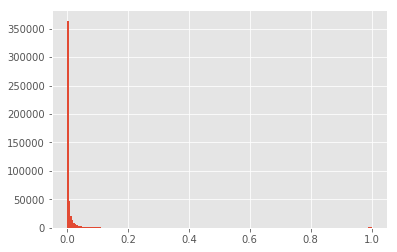

In [26]:
plt.hist(sample_submission['isFraud'],bins=200)
plt.show()

In [27]:
sample_submission.to_csv('../predictions/pred16.csv',index=False)

In [28]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred16.csv -m "pred16"

100%|███████████████████████████████████████| 14.3M/14.3M [00:33<00:00, 441kB/s]
Successfully submitted to IEEE-CIS Fraud Detection